# Final

<font size=4>Brady Arendale, Pankaj Kumar, Kay Ayala  
8/12/20</font>

# Introduction

We have been asked to analyze a dataset containing a number of censored variables. We do not know what any of the data represents. The objective is to classify the response variable in a way that minimizes the cost to the business. We know that each false positive costs \\$10 and each false negative costs \\$500. True positives and true negatives cost nothing. We will use various statistical and machine learning techniques to attempt to solve this problem.

# Exploratory data analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, make_scorer, recall_score


Bad key "text.kerning_factor" on line 4 in
/Users/pankaj/anaconda/envs/nlp/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
data = pd.read_csv('final_project.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 51 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   x0      159974 non-null  float64
 1   x1      159975 non-null  float64
 2   x2      159962 non-null  float64
 3   x3      159963 non-null  float64
 4   x4      159974 non-null  float64
 5   x5      159963 non-null  float64
 6   x6      159974 non-null  float64
 7   x7      159973 non-null  float64
 8   x8      159979 non-null  float64
 9   x9      159970 non-null  float64
 10  x10     159957 non-null  float64
 11  x11     159970 non-null  float64
 12  x12     159964 non-null  float64
 13  x13     159969 non-null  float64
 14  x14     159966 non-null  float64
 15  x15     159965 non-null  float64
 16  x16     159974 non-null  float64
 17  x17     159973 non-null  float64
 18  x18     159960 non-null  float64
 19  x19     159965 non-null  float64
 20  x20     159962 non-null  float64
 21  x21     15

We have 160,000 observations. We have 50 explanatory variables, x0-x49, and one response variable, y. We have 45 numerical variables and 5 categorical variables. We have a number of missing values, so we need to use some imputation strategies to fill in our missing data. However, no variable has more than 50 missing values, so this should not make too large of an impact on our results.

First, let's take a look at our distribution of positive and negative classes.

In [4]:
print(data.y.value_counts())
print(data.y.value_counts(normalize=True))

0    95803
1    64197
Name: y, dtype: int64
0    0.598769
1    0.401231
Name: y, dtype: float64


We have 95,803 negative observations and 64,197 positive observations. Negative observations make up about 59.9% of the data, while positive observations make up about 40.1%. There is some class imbalance, but it is most likely not enough to affect our models.

Let's take a look at correlations between variables to get an idea of the relations present in our data.

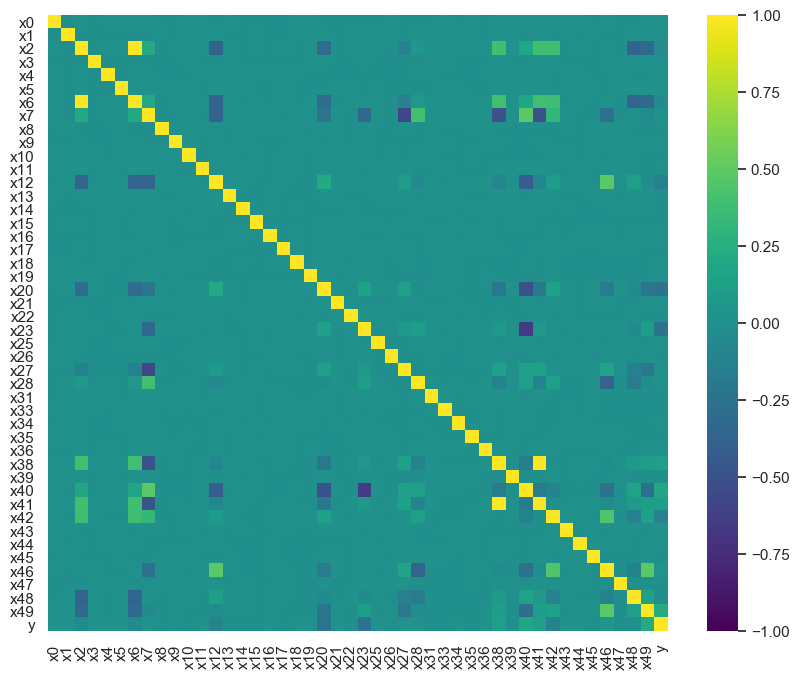

In [5]:
plt.style.use('default')
sns.set()
fig, ax = plt.subplots(1, 1, figsize=(10,8))
sns.heatmap(data.corr(), cmap='viridis', xticklabels=True,
            yticklabels=True, vmin=-1, vmax=1, ax=ax)
ax.set_xlim(0, 46)
ax.set_ylim(46, 0)
plt.show()

Most of our explanatory variables have very little correlation with each other. However, there are two pairs of variables that have extremely high correlation: x2 with x6, and x38 with x41. There are also some pairs of variables that have a high negative correlation, although not to the same extent as the two previous pairs.

Most variables have a very low, or even essentially zero, correlation with y. This suggests that many of these may not be useful in predicting y. We will have to either use models that can handle this themselves or use feature selection or dimensionality reduction to limit the number of variables that we pass into our models.

Let's take a look at the correlation between x2 and x6:

In [6]:
data.x2.corr(data.x6)

0.9999999999999994

And between x38 and x41:

In [7]:
data.x38.corr(data.x41)

0.999999999999999

Both of these pairs of variables are essentially perfectly correlated. We can see this by plotting them against each other:

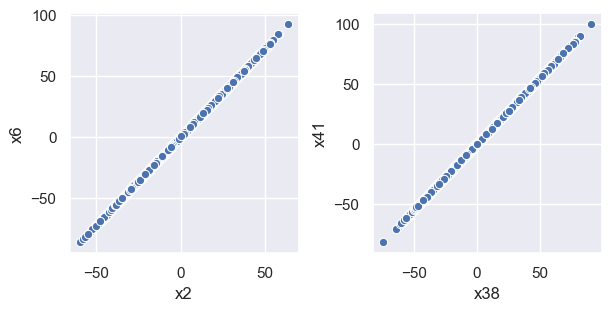

In [8]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(6,3), constrained_layout=True)
sns.scatterplot(data.x2, data.x6, ax=ax0)
sns.scatterplot(data.x38, data.x41, ax=ax1)
plt.show()

These variables have essentially a perfect linear relationship. This will likely pose a problem for any model that we put them into. We will solve this by dropping one column from each pair. It doesn't matter which, so we will just drop the second from each pair.

In [9]:
data.drop(columns=['x6','x41'], inplace=True)

Now let's take a look at some of our strong negative correlations:

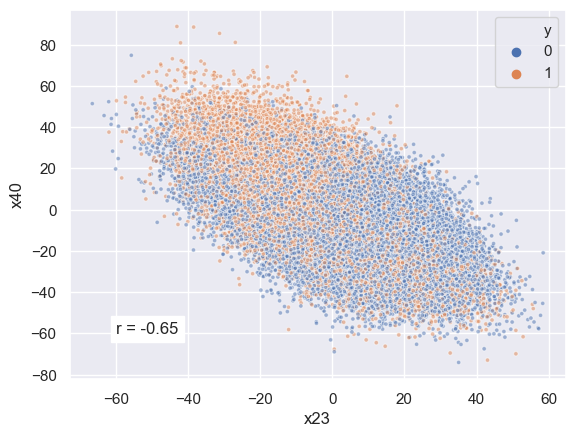

In [10]:
sns.scatterplot(data.x23, data.x40, hue=data.y, alpha=0.5, s=10)
plt.annotate("r = "+str(data.x23.corr(data.x40).round(2)), (-60,-60),
            backgroundcolor='white')
plt.show()

x23 and x40 have a strong negative correlation of -0.65. There might be a different distribution between positive and negative classes, but it is hard to tell with such a dense plot. Let's look at some comparisons:

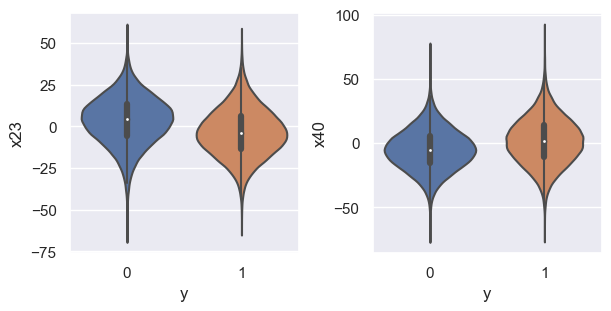

In [11]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(6,3), constrained_layout=True)
sns.violinplot(data.y, data.x23, ax=ax0)
sns.violinplot(data.y, data.x40, ax=ax1)
plt.show()

There appears to be a difference in distribution for each variable between the positive and negative classes. Both of these variables should be useful to our model.

Let's look at one more pair of variables:

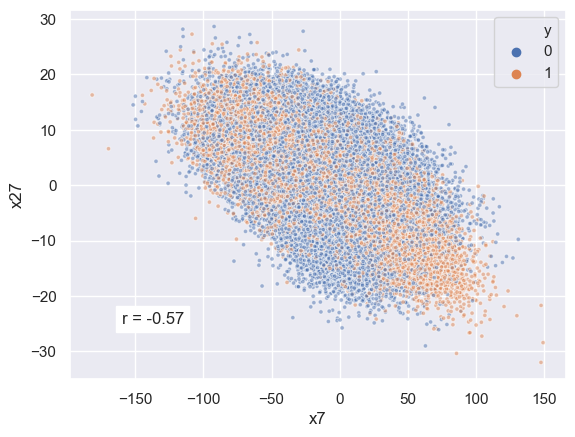

In [12]:
sns.scatterplot(data.x7, data.x27, hue=data.y, alpha=0.5, s=10)
plt.annotate("r = "+str(data.x7.corr(data.x27).round(2)), (-160,-25),
            backgroundcolor='white')
plt.show()

x7 and x27 have a moderate negative correlation. Again, there appears to be some separation between the positive and negative classes.

Let's look at some of our categorical variables now.

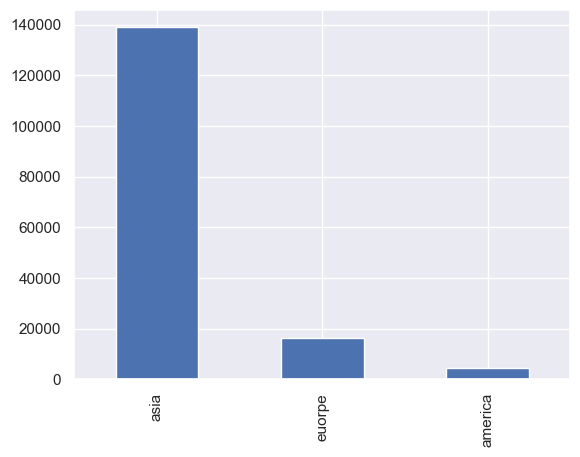

In [13]:
data.x24.value_counts().plot(kind='bar')
plt.show()

x24 appears to be related to continents. There is a much larger number of "asia" records than either "europe" or "america".

In [14]:
pd.crosstab(index=data.y, columns=data.x24, normalize='columns', margins=True)

x24,america,asia,euorpe,All
y,,,,
0,0.744686,0.591804,0.61791,0.598774
1,0.255314,0.408196,0.38209,0.401226


A cross-tabulation shows that "america" has a much higher than average percentage of negative classes. "asia" and "europe" are both close to average. This could help our models classify "america" records, but those only make up a small amount of our data.

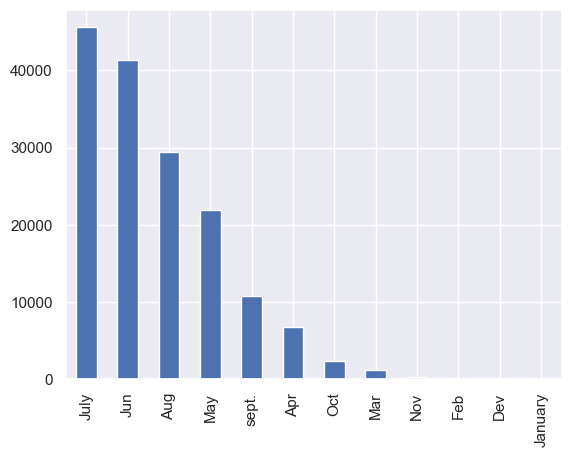

In [15]:
data.x29.value_counts().plot(kind='bar')
plt.show()

x29 appears to have month values. Months toward the middle of the year appear to have the most representation in our data. Some of them are misspelled or have different formatting, but these are consistent, so there is no need to correct them.

In [16]:
pd.crosstab(index=data.y, columns=data.x29, normalize='columns', margins=True)

x29,Apr,Aug,Dev,Feb,January,July,Jun,Mar,May,Nov,Oct,sept.,All
y,,,,,,,,,,,,,
0,0.594143,0.599129,0.521739,0.614286,0.666667,0.60065,0.599143,0.604387,0.595424,0.563798,0.589946,0.60024,0.598756
1,0.405857,0.400871,0.478261,0.385714,0.333333,0.39935,0.400857,0.395613,0.404576,0.436202,0.410054,0.39976,0.401244


A cross-tabulation shows that most of the categories have a class ratio very close to average. The ones with a ratio somewhat different from average, such as "Dev", "Feb", "January", and "Nov", have very little representation in the data, so these could just be different due to small sample sizes.

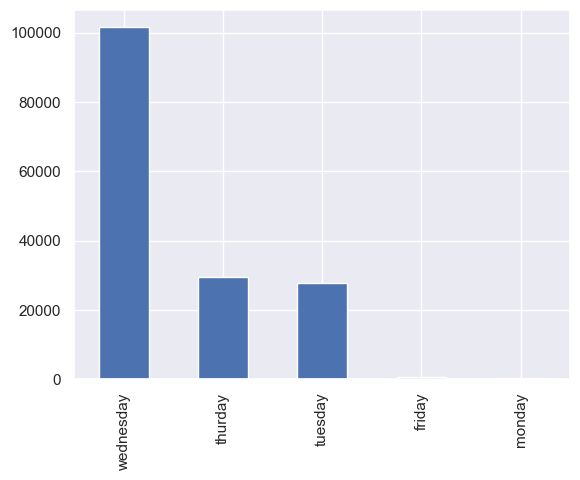

In [17]:
data.x30.value_counts().plot(kind='bar')
plt.show()

x30 appears to have information about days of the week. "wednesday" appears the most by far, with "friday" and "monday" having very few observations.

In [18]:
pd.crosstab(index=data.y, columns=data.x30, normalize='columns', margins=True)

x30,friday,monday,thurday,tuesday,wednesday,All
y,,,,,,
0,0.613475,0.60041,0.601991,0.600093,0.59742,0.598794
1,0.386525,0.39959,0.398009,0.399907,0.40258,0.401206


All of these categories have a class ratio very close to the average, so this variable is not likely to be useful for our models.

In [19]:
data.x32.value_counts()

0.01%     40767
-0.01%    34094
0.0%      33923
-0.0%     30492
-0.02%     9924
0.02%      7987
-0.03%     1727
0.03%       855
-0.04%      138
0.04%        55
-0.05%        6
0.05%         1
Name: x32, dtype: int64

x32 appears to be percents rather than actual categories. Let's convert it into a numerical variable.

In [20]:
data.x32 = data.x32.str.replace(pat='%', repl='')
data.x32 = data.x32.astype('float')

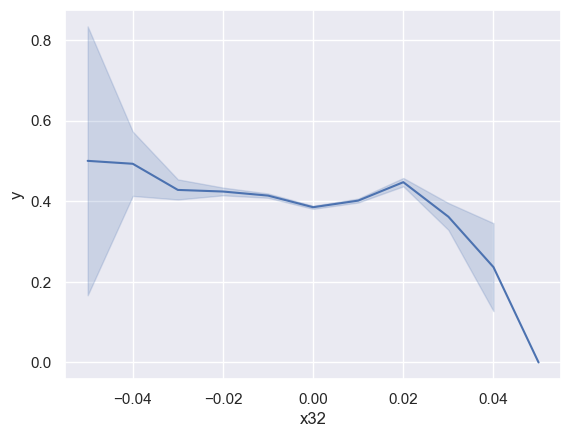

In [21]:
sns.lineplot(data.x32, data.y)
plt.show()

The percentage of positive classes appears to generally decrease for higher values of x32.

In [22]:
data.x37

0          $1313.96
1          $1962.78
2           $430.47
3         $-2366.29
4          $-620.66
            ...    
159995     $-891.96
159996     $1588.65
159997      $687.46
159998      $439.21
159999    $-1229.34
Name: x37, Length: 160000, dtype: object

x37 appears to be dollar amounts and again not an actual category. Let's convert it into a numerical variable.

In [23]:
data.x37 = data.x37.str.replace(pat='$', repl='')
data.x37 = data.x37.astype('float')

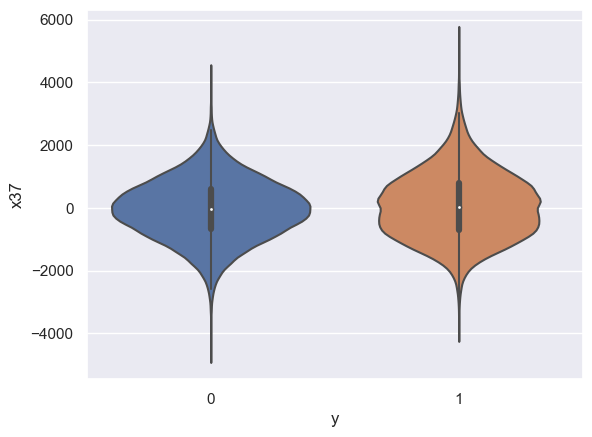

In [24]:
sns.violinplot(data.y, data.x37)
plt.show()

The positive class appears to be slightly more spread out than the negative class.

# Train-test split

We will split our data into an 80-20 train-test split. We will use a stratified split to ensure that both sets have an equal class ratio. Our training set will be used to fit our models, and we will then evaluate them on our test set to analyze their performance on unseen data.

In [25]:
y = data.pop('y')
X = data.copy()

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=9001)

In [27]:
X_train.shape

(128000, 48)

In [28]:
X_test.shape

(32000, 48)

Our training set has 128,000 observations, and our test set has 32,000 observations.

# Data imputation

We will now fill in our missing values. Let's look at the distribution of each variable in the training set to determine whether mean or median imputation is more appropriate.

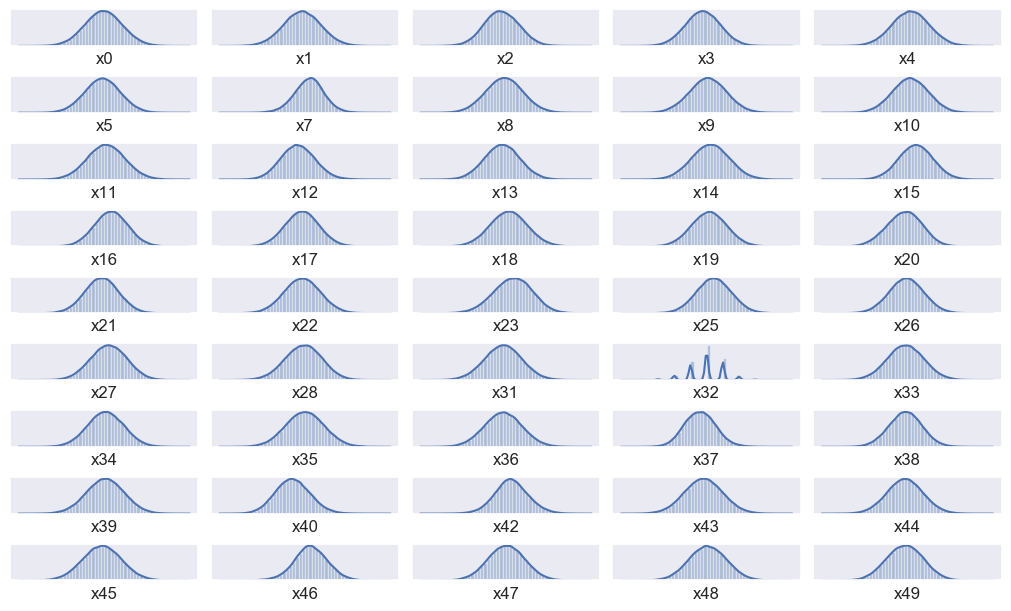

In [29]:
float_columns = X_train.columns[X_train.dtypes == 'float']

fig, axes = plt.subplots(9, 5, figsize=(10,6), constrained_layout=True)

for ax, col in zip(axes.flatten(), float_columns):
    sns.distplot(X_train[col].dropna(), ax=ax)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

We see that each variable is approximately normally distributed. Since the mean and median are equal for normal distributions, either one would be appropriate. The one exception is with x32, which is a discrete variable. Here the mean would give a result that doesn't exactly match one of the values, so the median would probably work better. We will impute the median for each of our numerical variables. For our categorical variables, we will impute the mode. We will impute both the training and test set using the medians and modes from only our training set to prevent data leakage.

In [30]:
categorical_columns = X_train.columns[data.dtypes == 'object']

for col in float_columns:
    impute_value = X_train[col].mean()
    X_train.loc[:,col] = X_train[col].fillna(value=impute_value)
    X_test.loc[:,col] = X_test[col].fillna(value=impute_value)

for col in categorical_columns:
    impute_value = X_train[col].mode().item()
    X_train.loc[:,col] = X_train[col].fillna(value=impute_value)
    X_test.loc[:,col] = X_test[col].fillna(value=impute_value)

/Users/pankaj/anaconda/envs/nlp/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [31]:
X_train.isna().sum().sum()

0

In [32]:
X_test.isna().sum().sum()

0

We no longer have any missing values in either our training set or test set.

# Data preprocessing

Before passing data into our models, we need to perform some preprocessing steps. First, we one-hot encode our categorical variables. This transforms our categorical columns into several numerical columns, which serve as indicator variables specifying if an observation falls into one category or not. The next step is to scale and center our data by subtracting the mean and dividing by the standard deviation for each column. This accounts for differences in scale between variables, which helps make our models well-behaved. We calculate the means and standard deviations of each column in the training set, and then use those values to standardize both the training set and test set. This ensures that our scaled values have the same meaning in both sets.

In [33]:
onehot = OneHotEncoder(handle_unknown='ignore')

col_transform = ColumnTransformer(
    transformers=[('OneHot', onehot, categorical_columns)],
    remainder='passthrough'
)

col_transform.fit(X_train)
X_train = col_transform.transform(X_train)
X_test = col_transform.transform(X_test)

In [34]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Modeling

We will now fit several models to our data. We will test several configurations for each model using a randomized grid search. We create a list of hyperparameter values that we want to search over, and the randomized grid search algorithm takes random combinations of those hyperparameter values and fits a certain number of models. This takes less computation time than an exhaustive grid search testing all possible combinations and performs nearly as well. We will use 5-fold stratified cross-validation to calculate a range of scores for each combination. This separates the data into 5 chunks with equal class balance and uses each chunk as a test set once while the model is trained on the other 4 chunks. Using this technique, we train 5 models for each hyperparameter combination to get a better estimate of out-of-sample error.

In scoring our models, we keep in mind the costs of both false positives and false negatives. We know that false negatives are much more costly than false positives. Since we know the precise cost associated with each, we implement this in a custom metric that we call the mean cost:
<p>
<center>$mean~cost = \frac{(-10*fp)+(-500*fn)}{tp+tn+fp+fn}$</center>

This tells us the expected cost per prediction of each model. We also evaluate our models using recall, defined as the ratio of true positives to true positives plus false negatives, to determine how many of the potentially-costly positives that we classified correctly.

In [35]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=9001)

In [36]:
def mean_cost(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return (-10*fp-500*fn)/len(y_true)

mean_cost_scorer = make_scorer(score_func=mean_cost)

### PCA 

In [50]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train) 

train_for_pca = scaler.transform(X_train)
test_for_pca = scaler.transform(X_test)
pca = PCA(n_components=20)
pca.fit(train_for_pca)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
sum(pca.explained_variance_ratio_)

[0.0537562  0.04371996 0.03126868 0.02723782 0.02657142 0.02610084
 0.02258324 0.02074107 0.01926611 0.01792561 0.01730477 0.0169658
 0.01655288 0.01600682 0.0157083  0.01560813 0.01557775 0.01555894
 0.01550386 0.01547032]
[668.7687205  603.11695394 510.05434584 476.0448263  470.18530804
 466.00324586 433.46577879 415.4102785  400.36734894 386.18791426
 379.4412942  375.70660023 371.10638527 364.93385157 361.51488898
 360.3604745  360.00953552 359.79216756 359.15474453 358.76600637]


0.4494285297418964

### Neural Network 

In [56]:
import tensorflow as tf
import numpy as np
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(100))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['binary_crossentropy'])
history = model.fit(X_train, np.array(y_train), epochs = 5, batch_size = 64)
y_pred = model.predict_classes(X_test)


Train on 128000 samples
Epoch 1/5
128000/128000 [==============================] - 4s 33us/sample - loss: 4.3962 - binary_crossentropy: 4.39620s - loss: 4.4123 - binary_crossentropy: 
Epoch 2/5
128000/128000 [==============================] - 4s 32us/sample - loss: 4.3052 - binary_crossentropy: 4.3052
Epoch 3/5
128000/128000 [==============================] - 4s 34us/sample - loss: 4.8058 - binary_crossentropy: 4.8058
Epoch 4/5
128000/128000 [==============================] - 4s 31us/sample - loss: 4.2882 - binary_crossentropy: 4.2882
Epoch 5/5
128000/128000 [==============================] - 4s 33us/sample - loss: 4.0262 - binary_crossentropy: 4.0262


In [55]:
y_pred = clf.predict(X_test)
mean_cost(np.array(y_test), y_pred)

-90.725

### SGD Classifier 

In [63]:
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
sgd_params = {'average': [True, False],
              'l1_ratio': np.linspace(0, 1, num=10),
              'alpha': np.power(10, np.arange(-4, 1, dtype=float))}

sgd_model = RandomizedSearchCV(
    SGDClassifier(),
    param_distributions=sgd_params,
    n_iter=20,
    scoring=mean_cost_scorer,
    n_jobs=-1,
    cv=cv,
    random_state=9001,
    verbose=1
)

sgd_model.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.2s finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=9001, shuffle=True),
                   error_score=nan,
                   estimator=SGDClassifier(alpha=0.0001, average=False,
                                           class_weight=None,
                                           early_stopping=False, epsilon=0.1,
                                           eta0=0.0, fit_intercept=True,
                                           l1_ratio=0.15,
                                           learning_rate='optimal',
                                           loss='hinge', max_iter=1000,
                                           n_iter_no_change=5, n_jobs=None,
                                           penalty='l2', power_t=0.5,
                                           ra...
                   iid='deprecated', n_iter=20, n_jobs=-1,
                   param_distributions={'alpha': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00]),
                                        'aver

In [64]:
y_pred = sgd_model.predict(X_train)
recall_score(y_train, y_pred)

0.5054713968612485

In [65]:
sgd_model.score(X_train, y_train)

-100.230234375

## Elastic net logistic regression

In [ ]:
log_params = {
    'l1_ratio': [0,0.05,0.1,0.3,0.5,0.7,0.9,0.95,1],
    'C': np.logspace(-4, 4, num=10),
    'class_weight': [None, 'balanced']
}

log_model = RandomizedSearchCV(
    LogisticRegression(penalty='elasticnet', solver='saga', 
                       max_iter=100, random_state=9001),
    param_distributions=log_params,
    n_iter=20,
    scoring=mean_cost_scorer,
    n_jobs=-1,
    cv=cv,
    random_state=9001,
    verbose=1
)

log_model.fit(X_train, y_train)

In [ ]:
log_model.best_params_

In [3]:
log_model.score(X_train, y_train)

NameError: name 'log_model' is not defined

In [ ]:
log_pred = log_model.predict(X_train)
recall_score(y_train, log_pred)

## Random forest

In [ ]:
rf_params = {
    'n_estimators': [10, 100, 200, 500],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5, 10],
    'class_weight': [None, 'balanced']
}

rf_model = RandomizedSearchCV(
    RandomForestClassifier(random_state=9001),
    param_distributions=rf_params,
    n_iter=20,
    scoring=mean_cost_scorer,
    n_jobs=-1,
    cv=cv,
    random_state=9001,
    verbose=1
)

rf_model.fit(X_train, y_train)

In [ ]:
X_test.shape

In [ ]:
mean_cost(np.array(y_test), y_pred)

In [ ]:
X_test.shape